In [1]:
%matplotlib inline

import sys
sys.path.append('./tree-parser')

import collections
import math
import numpy as np
import random
import csv

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from matplotlib import pylab
from sklearn.manifold import TSNE

import rntn
import tree as tr

In [2]:
dim = 10
output_dim = 5
batch_size = 30
reg = 1e-6
lr = 1e-1
epochs = 10

# Load or train the model
model_filename = "models/final-models/visual_model_sst5.pickle"

#model = rntn.RNTN(dim=dim, output_dim=output_dim, batch_size=batch_size, 
#                 reg=reg, learning_rate=lr, max_epochs=epochs)

# Train
train_trees = tr.load_trees('train')
#model.train(train_trees, model_filename=model_filename)

model = rntn.RNTN.load(model_filename)

Reading trees/train.txt...
Model loaded successfully from file models/final-models/visual_model_sst5.pickle


In [3]:
num_points = 400
embeddings = model.embedding.T

norm = np.sqrt(np.sum(np.square(embeddings), 0, keepdims=True))
normalized_embeddings = embeddings / norm

embedding_slice = normalized_embeddings[1:num_points + 1, :]

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
print(embedding_slice.shape)
two_d_embeddings = tsne.fit_transform(embedding_slice)
print(two_d_embeddings.shape)

(400, 10)
(400, 2)


In [4]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:] # Transformed to 2D
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
        #pylab.rcParams.update({'font.size': 20})
    pylab.show()

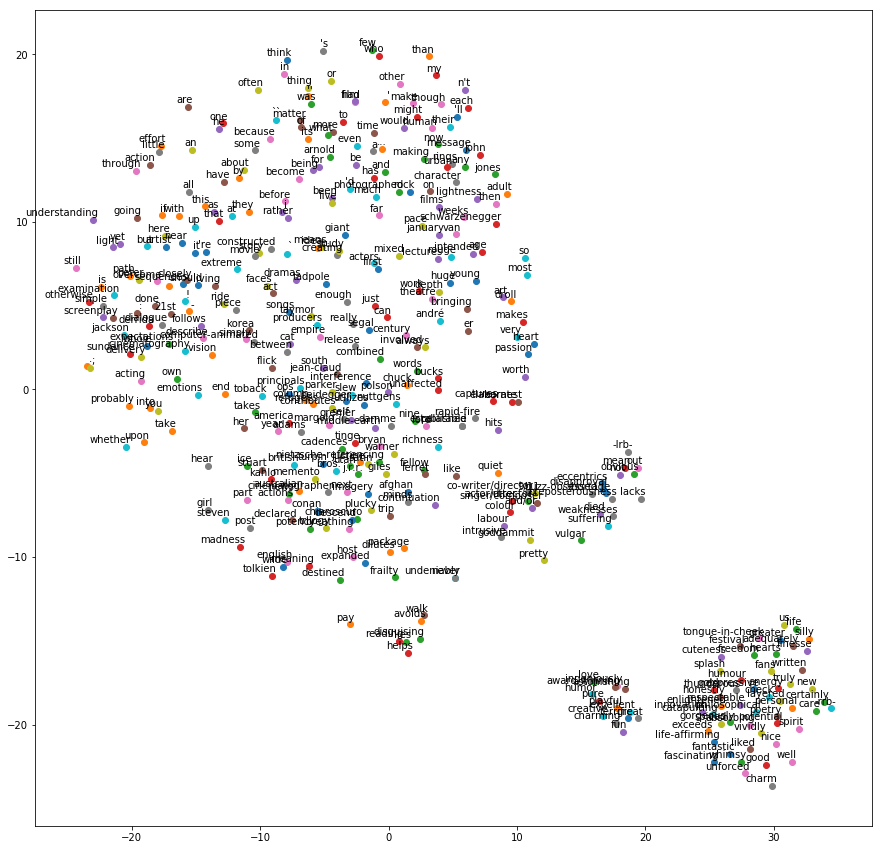

In [5]:
reverse_dictionary = dict(zip(model.dictionary.values(), model.dictionary.keys())) 
words = [reverse_dictionary[i] for i in range(1, num_points + 1)]

plot(two_d_embeddings, words)

In [6]:
# Try to visualize positive and negative words
word_size = 100
positive_words = set()
negative_words = set()
neutral_words = set()

for tree in train_trees:
    for label, leaf in tree.labeled_leaves():
        pos_words_len = len(positive_words)
        neu_words_len = len(neutral_words)
        neg_words_len = len(negative_words)
        
        if label == 4 and pos_words_len < word_size:
            positive_words.add(leaf)
        elif label == 2 and neu_words_len < word_size and leaf.isalpha():
            neutral_words.add(leaf)
        elif label == 0 and neg_words_len < word_size:
            negative_words.add(leaf)
    
    if pos_words_len >= word_size and neu_words_len >= word_size and neg_words_len >= word_size:
        break

print(positive_words)
print()
print(neutral_words)
print()
print(negative_words)

{'pure', 'excellent', 'dazzling', 'extraordinarily', 'sweet', 'wiser', 'poignant', 'exhilarating', 'freedom', 'smart', 'entertaining', 'honest', 'delightful', 'encourage', 'celebrate', 'confident', 'glorious', 'brilliant', 'playful', 'exquisite', 'nicest', 'thrills', 'uplifting', 'love', 'pleasure', 'priceless', 'goodies', 'fun', 'pretty', 'worthy', 'amusing', 'terrific', 'sweetheart', 'masterpiece', 'imaginative', 'humor', 'sparkles', 'marvelous', 'cutting-edge', 'superb', 'enjoy', 'powerful', 'shines', 'winner', 'entertained', 'remarkable', 'oscar-worthy', 'elegant', 'beautiful', 'enthralling', 'astonishing', 'sexy', 'spirited', 'four-star', 'successful', 'ingenious', 'top-notch', 'hot', 'fresh', 'genuine', 'impressive', 'engaging', 'captivating', 'hope', 'majestic', 'must-see', 'masterfully', 'satisfying', 'best', 'hilarious', 'grand', 'great', 'thrilling', 'darling', 'engrossing', 'clever', 'perfect', 'kids-and-family-oriented', 'perfectly', 'oscar-sweeping', 'unforgettable', 'thou

In [7]:
positive_words_vectors = np.zeros((word_size,dim))
negative_words_vectors = np.zeros((word_size,dim))
neutral_words_vectors = np.zeros((word_size,dim))

for idx, positive_word in enumerate(positive_words):
    if positive_word in model.dictionary:
        positive_words_vectors[idx] = normalized_embeddings[model.dictionary[positive_word], :]
    
for idx, neutral_word in enumerate(neutral_words):
    if neutral_word in model.dictionary:
        neutral_words_vectors[idx] = normalized_embeddings[model.dictionary[neutral_word], :]
    
for idx, negative_word in enumerate(negative_words):
    if negative_word in model.dictionary:
        negative_words_vectors[idx] = normalized_embeddings[model.dictionary[negative_word], :]

pnembed = np.vstack([positive_words_vectors, negative_words_vectors])
pnnembed = np.vstack([positive_words_vectors, neutral_words_vectors, negative_words_vectors])

In [ ]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=10000, method='exact')

twod_embed_2_classes = tsne.fit_transform(pnembed)
twod_embed_3_classes = tsne.fit_transform(pnnembed)

words_2_classes = []
words_3_classes = []

for pos_word in positive_words:
    words_2_classes.append(pos_word + " 4")
    
for neg_word in negative_words:
    words_2_classes.append(neg_word + " 0")
    
for neu_word in neutral_words:
    words_3_classes.append(neu_word + " 2")
    
words_3_classes.extend(words_2_classes)

plot(twod_embed_2_classes, words_2_classes)
plot(twod_embed_3_classes, words_3_classes)

In [ ]:
def closest_to_vector(vector_to_test, embeddings, reverse_dictionary):
    cosine_similarities = []
    # -1 - opposite, 1 - the same
    # cosine similarity = 1 - cosine distance
    for idx, vector in enumerate(embeddings):
        cosine_similarities.append((reverse_dictionary[idx], 1 - spatial.distance.cosine(vector_to_test, vector)))
    cosine_similarities.sort(reverse = True, key=lambda x:x[1])
    return cosine_similarities[1:11]

In [ ]:
from scipy import spatial

random_positive_word = random.sample(positive_words, 1)[0]
random_positive_word_vector = embeddings[model.dictionary[random_positive_word], :]
print("The positive word is: %s" % random_positive_word)
print("Vector for the word is: %s" % (random_positive_word_vector))

words = []

print("\nClosest 10 words to this vector are:")
for word, distance in closest_to_vector(random_positive_word_vector, embeddings, reverse_dictionary):
    print("('%s', %.3f)" % (word, distance), end = " ") 

print()
random_negative_word = random.sample(negative_words, 1)[0]
random_negative_word_vector = embeddings[model.dictionary[random_negative_word], :]
print()
print("The negative word is: %s" % random_negative_word)
print("Vector for the word is: %s" % (random_negative_word_vector))

words = []

print("\nClosest 10 words to this vector are:")
for word, distance in closest_to_vector(random_negative_word_vector, embeddings, reverse_dictionary):
    print("('%s', %.3f)" % (word, distance), end = " ") 

In [ ]:
model_filename = "models/final-models/visual_model_sst2.pickle"
model_sst2 = rntn.RNTN.load(model_filename)

In [ ]:
# Try to visualize positive and negative words
import random
word_size = 100
positive_words = set()
negative_words = set()

train_trees = tr.load_trees('train', binary=True)
random.shuffle(train_trees)

for tree in train_trees:
    for label, leaf in tree.labeled_leaves():
        pos_words_len = len(positive_words)
        neg_words_len = len(negative_words)
        
        if label == 1 and pos_words_len < word_size and leaf.isalpha():
            positive_words.add(leaf)
        elif label == 0 and neg_words_len < word_size and leaf.isalpha():
            negative_words.add(leaf)
    
    if pos_words_len >= word_size and neg_words_len >= word_size:
        break

print(positive_words)
print()
print(negative_words)

In [ ]:
positive_words_vectors = np.zeros((word_size,dim))
negative_words_vectors = np.zeros((word_size,dim))

embeddings = model_sst2.embedding.T

norm = np.sqrt(np.sum(np.square(embeddings), 0, keepdims=True))
normalized_embeddings = embeddings / norm

for idx, positive_word in enumerate(positive_words):
    if positive_word in model.dictionary:
        positive_words_vectors[idx] = normalized_embeddings[model_sst2.dictionary[positive_word], :]
    
for idx, negative_word in enumerate(negative_words):
    if negative_word in model.dictionary:
        negative_words_vectors[idx] = normalized_embeddings[model_sst2.dictionary[negative_word], :]

embedvstack = np.vstack([positive_words_vectors, negative_words_vectors])

In [ ]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=10000, method='exact')

twod_embed_classes = tsne.fit_transform(embedvstack)

words = []

for pos_word in positive_words:
    words.append(pos_word + " 1")

for neg_word in negative_words:
    words.append(neg_word + " 0")
    

plot(twod_embed_classes, words)

In [ ]:
def read_confusion_matrix(filename):
    conf_matrix = []
    with open(filename, mode ='r') as file_to_read: 
        file = csv.reader(file_to_read, delimiter=' ')
        for line in file:
            conf_matrix.append([float(i) for i in line])
            
    return np.array(conf_matrix)

In [ ]:
path_to_sst2_root_cm = "models/final-models/results/sst2-root-results.txt"
path_to_sst5_root_cm = "models/final-models/results/sst5-root-results.txt"
path_to_sst2_all_cm = "models/final-models/results/sst2-all-results.txt"
path_to_sst5_all_cm = "models/final-models/results/sst5-all-results.txt"

In [ ]:
cm = read_confusion_matrix(path_to_sst2_root_cm)
print(cm)
print()
print("SST-2 root accuracy: %.3f" % (cm.trace() / cm.sum()))

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"])

pylab.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

plt.show()

In [ ]:
cm = read_confusion_matrix(path_to_sst2_all_cm)
print(cm)
print()
print("SST-2 all nodes accuracy: %.3f" % (cm.trace() / cm.sum()))

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"])

pylab.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

plt.show()

In [ ]:
# row = true label, column = predicted

cm = read_confusion_matrix(path_to_sst5_root_cm)
print(cm)
print()
print("SST-5 root nodes accuracy: %.3f" % (cm.trace() / cm.sum()))

df_cm = pd.DataFrame(cm, index = [i for i in "01234"],
                  columns = [i for i in "01234"])

pylab.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

plt.show()

In [ ]:
cm = read_confusion_matrix(path_to_sst5_all_cm)
print(cm)
print()
print("SST-5 all nodes accuracy: %.3f" % (cm.trace() / cm.sum()))

df_cm = pd.DataFrame(cm, index = [i for i in "01234"],
                  columns = [i for i in "01234"])

pylab.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

plt.show()